In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1,
                                               output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1,
                                               output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1,
                                               output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1,
                                               output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, x):
        contracting_11_out = self.contracting_11(x)  # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out)  # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out)  # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out)  # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out)  # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out)  # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out)  # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out)  # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out)  # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out)  # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(
            torch.cat((expansive_11_out, contracting_41_out), dim=1))  # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out)  # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(
            torch.cat((expansive_21_out, contracting_31_out), dim=1))  # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out)  # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(
            torch.cat((expansive_31_out, contracting_21_out), dim=1))  # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out)  # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(
            torch.cat((expansive_41_out, contracting_11_out), dim=1))  # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out)  # [-1, num_classes, 256, 256]
        return output_out

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [4]:
data_dir = '../input/cityscapes-image-pairs/cityscapes_data'
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_set = os.listdir(train_dir)
val_set = os.listdir(val_dir)
print(len(train_set), len(val_set))

2975 500


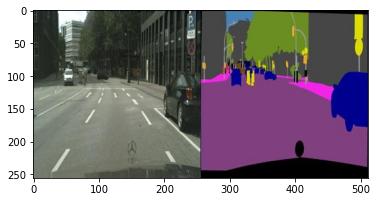

In [5]:
sample_image_path = os.path.join(train_dir, train_set[0])
sample_image = Image.open(sample_image_path).convert("RGB")
plt.imshow(sample_image)

In [6]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

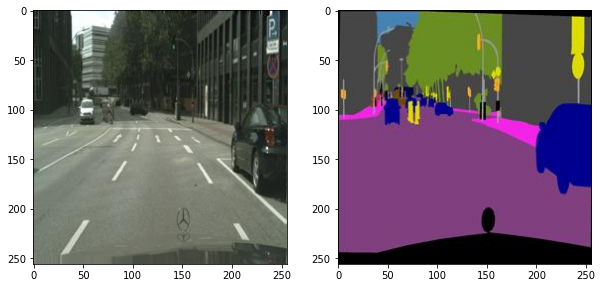

In [7]:
cityscape, label = split_image(sample_image)

cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(cityscape)
axes[1].imshow(label)

In [8]:
num_items = 1000
num_classes = 10
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

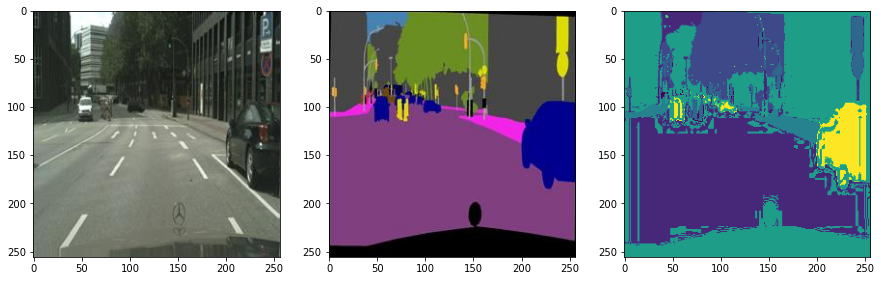

In [9]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [10]:
class CityScapeDataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_paths = os.listdir(image_dir)
        self.label_model = label_model
    
    def __len__(self):
        return len(self.image_paths)
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)
    
    def __getitem__(self, index):
        image_full_path = os.path.join(self.image_dir,
                                    self.image_paths[index])
        image = Image.open(image_full_path).convert('RGB')
        cityscape, label = self.split_image(image)
        label = label.reshape(-1,3)
        label_class = self.label_model.predict(label).reshape(256,256)
        
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        
        return cityscape, label_class     

In [11]:
batch_size = 16
epochs = 12
lr = 0.001

In [12]:
dataset = CityScapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [13]:
model = UNet(num_classes=num_classes).to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [15]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
    
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
        
    epoch_losses.append(epoch_loss/len(data_loader))

In [16]:
test_batch_size = 8
dataset = CityScapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [17]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [18]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

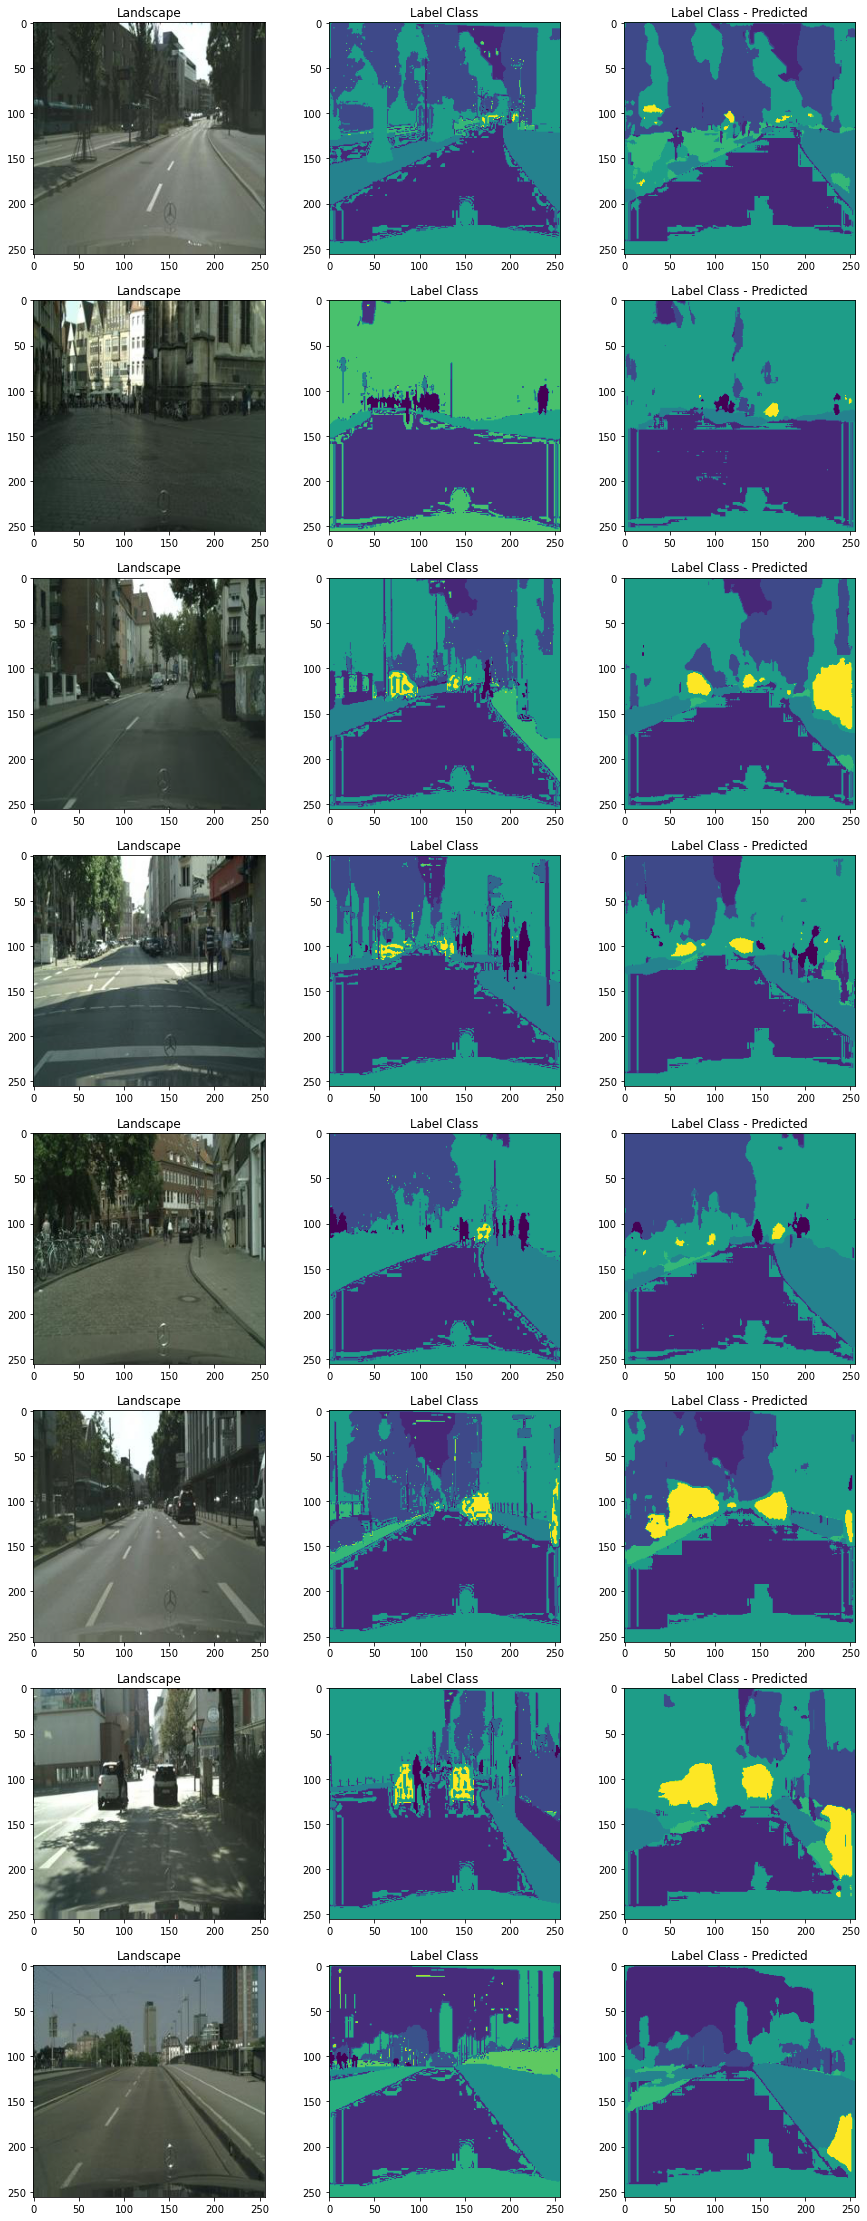

In [19]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [2]:
!pip install jovian
import jovian
jovian.commit(project='cityscape-image-segmentation')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ai/gitrohitjain/cityscape-image-segmentation


<IPython.core.display.Javascript object>